# Classification

## Simulate data

Below, we simulate data.

* $X_1 \sim \mathcal{N}(0, 1)$
* $X_2 \sim \mathcal{N}(0, 1)$
* $Y_0 = 1 + 2X_1 + 3X_2 + \sigma$
* $Y_1 = \frac{1}{1 + \exp(-Y_0)}$
* $y \sim \mathcal{Binom}(Y_1)$

In [1]:
suppressMessages({
    library('dplyr')
})

set.seed(37)

getData <- function(N=1000) {
    x1 <- rnorm(N, mean=0, sd=1)
    x2 <- rnorm(N, mean=0, sd=1)
    y <- 1 + 2.0 * x1 + 3.0 * x2 + rnorm(N, mean=0, sd=1)
    y <- 1.0 / (1.0 + exp(-y))
    y <- rbinom(n=N, size=1, prob=y)
    
    df <- data.frame(x1=x1, x2=x2, y=y)
    df <- df %>% 
            mutate(y=ifelse(y == 0, 'neg', 'pos')) %>%
            mutate_if(is.character, as.factor)
    return(df)
}

T <- getData()
V <- getData()

print(summary(T))

       x1                x2             y      
 Min.   :-2.8613   Min.   :-3.28763   neg:394  
 1st Qu.:-0.6961   1st Qu.:-0.59550   pos:606  
 Median :-0.0339   Median : 0.06348            
 Mean   :-0.0184   Mean   : 0.03492            
 3rd Qu.: 0.6836   3rd Qu.: 0.69935            
 Max.   : 3.8147   Max.   : 3.17901            


## Classification methods

There are many classifcation models available in `R`. We only show a few here and use the [pROC](https://cran.r-project.org/web/packages/pROC/pROC.pdf) package to visualize the performance.

### Random forest

Using [random forest](https://cran.r-project.org/web/packages/randomForest/randomForest.pdf).

In [2]:
suppressMessages({
    library('pROC')
    library('randomForest')
})

m <- randomForest(y ~ ., data=T, mtry=2, ntree=1000)

In [3]:
print(m)


Call:
 randomForest(formula = y ~ ., data = T, mtry = 2, ntree = 1000) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 2

        OOB estimate of  error rate: 20.6%
Confusion matrix:
    neg pos class.error
neg 287 107   0.2715736
pos  99 507   0.1633663


In [4]:
p <- predict(m, newdata=V, type='prob')
y_pred = p[,2]

r <- roc(V$y, y_pred, levels=c('neg', 'pos'), direction='<')
print(r)


Call:
roc.default(response = V$y, predictor = y_pred, levels = c("neg",     "pos"), direction = "<")

Data: y_pred in 402 controls (V$y neg) < 598 cases (V$y pos).
Area under the curve: 0.9062


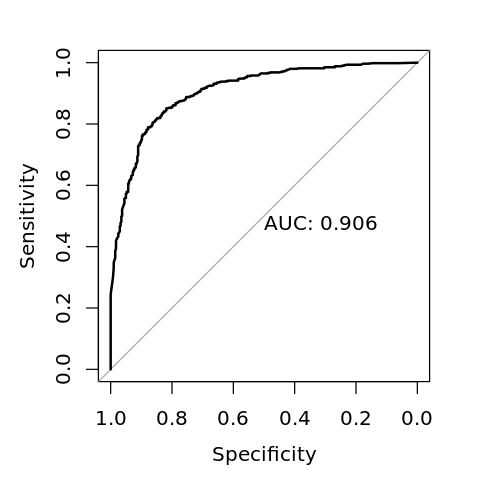

In [5]:
options(repr.plot.width=4, repr.plot.height=4)

plot(r, print.auc=TRUE)

### Logistic regression

Using [logistic regression](https://www.rdocumentation.org/packages/stats/versions/3.6.1/topics/glm).

In [6]:
m <- glm(y ~ ., family='binomial', data=T)

In [7]:
print(m)


Call:  glm(formula = y ~ ., family = "binomial", data = T)

Coefficients:
(Intercept)           x1           x2  
     0.7692       1.6568       2.3364  

Degrees of Freedom: 999 Total (i.e. Null);  997 Residual
Null Deviance:	    1341 
Residual Deviance: 724.4 	AIC: 730.4


In [8]:
y_pred <- predict(m, newdata=V, type='response')

r <- roc(V$y, y_pred, levels=c('neg', 'pos'), direction='<')
print(r)


Call:
roc.default(response = V$y, predictor = y_pred, levels = c("neg",     "pos"), direction = "<")

Data: y_pred in 402 controls (V$y neg) < 598 cases (V$y pos).
Area under the curve: 0.933


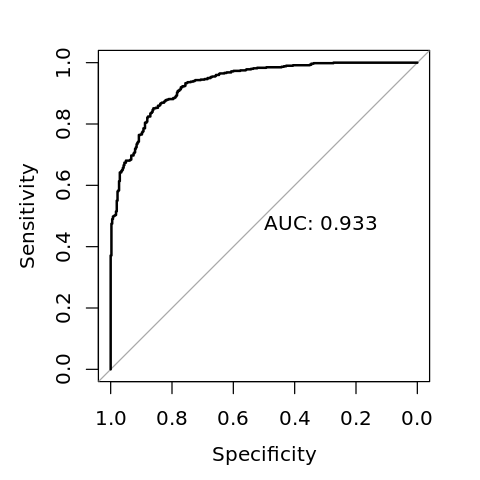

In [9]:
options(repr.plot.width=4, repr.plot.height=4)

plot(r, print.auc=TRUE)

### AdaBoost

Using [AdaBoost](https://cran.r-project.org/web/packages/fastAdaboost/fastAdaboost.pdf).

In [10]:
library('fastAdaboost')

m <- adaboost(y ~ ., nIter=50, data=T)

In [11]:
print(m)

adaboost(formula = y ~ ., data = T, nIter = 50)
y ~ .
Dependent Variable: y
No of trees:50
The weights of the trees are:0.96387420.80235240.71526760.63439580.63139020.58530950.62330850.58756820.53374960.5300160.50916270.55428910.54749730.60577360.55118370.54656730.49836120.53329020.48512470.46704230.51634080.52241440.53706090.55988470.55272350.56468040.54326980.53403390.5140650.51328940.54461680.49396760.4945920.45737710.47303330.63182430.52913920.57678280.54805410.53541630.56575640.53455380.53633590.51994930.53944080.56411030.51954350.54601860.48144430.5298128


In [12]:
p <- predict(m, newdata=V)
y_pred <- p$prob[,2]

r <- roc(V$y, y_pred, levels=c('neg', 'pos'), direction='<')
print(r)


Call:
roc.default(response = V$y, predictor = y_pred, levels = c("neg",     "pos"), direction = "<")

Data: y_pred in 402 controls (V$y neg) < 598 cases (V$y pos).
Area under the curve: 0.8936


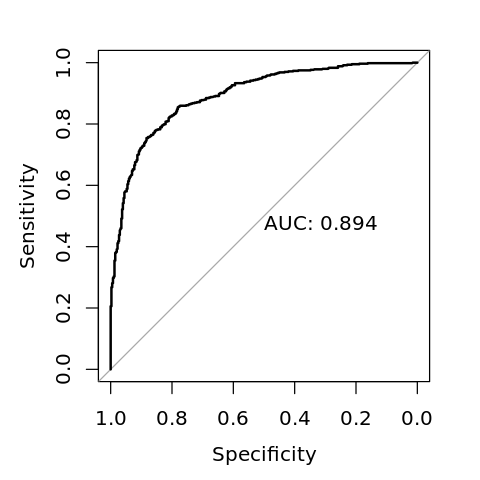

In [13]:
options(repr.plot.width=4, repr.plot.height=4)

plot(r, print.auc=TRUE)

### Support vector machine

Using [support vector machine](https://cran.r-project.org/web/packages/e1071/e1071.pdf) `SVM`.

In [14]:
library('e1071')

m <- svm(y ~ ., probability=TRUE, data=T)

In [15]:
print(m)


Call:
svm(formula = y ~ ., data = T, probability = TRUE)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 

Number of Support Vectors:  405



In [16]:
p <- predict(m, newdata=V, probability=TRUE)
y_pred <- attr(p, 'probabilities')[,1]

r <- roc(V$y, y_pred, levels=c('neg', 'pos'), direction='<')
print(r)


Call:
roc.default(response = V$y, predictor = y_pred, levels = c("neg",     "pos"), direction = "<")

Data: y_pred in 402 controls (V$y neg) < 598 cases (V$y pos).
Area under the curve: 0.9166


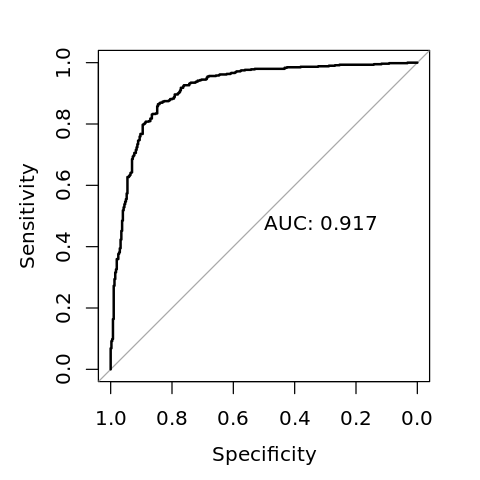

In [17]:
options(repr.plot.width=4, repr.plot.height=4)

plot(r, print.auc=TRUE)